<a href="https://colab.research.google.com/github/aslestia/ACS_2025/blob/main/ACS_Week05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Week 5 Lab: Variance vs VaR vs CVaR vs EVaR

**Tujuan:** Menghitung CVaR & EVaR pada data return sintetis dan membandingkannya dengan Variance.

**Langkah:**
1. Simulasikan return i.i.d. (mis. Normal dan heavy-tail: lognormal, student-t).
2. Pilih level kepercayaan: α ∈ {0.90, 0.95, 0.99}.
3. Hitung Variance, VaR, CVaR, EVaR.
4. Bandingkan numerik dan buat plot distribusi dengan garis vertikal pada mean, VaR, CVaR, EVaR.

> Catatan: Untuk data *return*, ukuran risiko didefinisikan pada *loss* L = -R (ekor kiri pada return setara ekor kanan pada loss).


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Konfigurasi dasar
np.random.seed(123)
ALPHAS = [0.90, 0.95, 0.99]

# Fungsi utilitas
def empirical_VaR(sample, alpha, tail='right'):
    """Empirical VaR at level alpha.
    tail='right' untuk loss (ekor kanan). tail='left' untuk return (ekor kiri).
    """
    if tail == 'right':
        return np.quantile(sample, alpha)
    else:
        return np.quantile(sample, 1 - alpha)  # left tail

def empirical_CVaR(sample, alpha, tail='right'):
    var = empirical_VaR(sample, alpha, tail=tail)
    if tail == 'right':
        tail_vals = sample[sample >= var]
    else:
        tail_vals = sample[sample <= var]
    return tail_vals.mean() if tail_vals.size > 0 else var

def empirical_EVaR(sample, alpha, tail='right', theta_grid=None):
    """EVaR via empirical MGF with 1D search over theta>0."""
    x = sample if (tail=='right') else -sample  # untuk return, konversi ke loss
    if theta_grid is None:
        theta_grid = np.logspace(-3, 2, 400)  # 0.001 s/d 100
    mgf = lambda t: np.mean(np.exp(t * x))
    vals = [(np.log(mgf(t)) - np.log(1 - alpha)) / t for t in theta_grid]
    return min(vals)

def plot_with_markers(sample, alpha, title, filename, tail='right', bins=80):
    mean_val = np.mean(sample)
    var = empirical_VaR(sample, alpha, tail=tail)
    cvar = empirical_CVaR(sample, alpha, tail=tail)
    evar = empirical_EVaR(sample, alpha, tail=tail)

    plt.figure(figsize=(8,4))
    plt.hist(sample, bins=bins, density=True, alpha=0.6, label='Histogram')
    plt.axvline(mean_val, linestyle='-', linewidth=2, label=f'Mean = {mean_val:.3f}')
    plt.axvline(var, linestyle='--', linewidth=2, label=f'VaR {int(alpha*100)}% = {var:.3f}')
    plt.axvline(cvar, linestyle='-.', linewidth=2, label=f'CVaR {int(alpha*100)}% = {cvar:.3f}')
    if tail=='right':
        evar_line = evar
    else:
        evar_line = -empirical_EVaR(sample, alpha, tail=tail)
    plt.axvline(evar_line, linestyle=':', linewidth=2, label=f'EVaR {int(alpha*100)}% = {evar_line:.3f}')
    plt.title(title + f' (alpha={alpha:.2f})')
    plt.xlabel('Nilai')
    plt.ylabel('Kerapatan')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.show()
    plt.close()

def summarize(sample, name, tail='right'):
    rows = []
    for a in ALPHAS:
        rows.append({
            'Dataset': name,
            'Tail': tail,
            'alpha': a,
            'Mean': sample.mean(),
            'Variance': sample.var(ddof=1),
            'VaR': empirical_VaR(sample, a, tail=tail),
            'CVaR': empirical_CVaR(sample, a, tail=tail),
            'EVaR': empirical_EVaR(sample, a, tail=tail) if tail=='right' else -empirical_EVaR(sample, a, tail=tail)
        })
    return pd.DataFrame(rows)



## 1) Loss-style data (ekor kanan)
- **Normal(0,1)** (simetris),
- **Lognormal(0, 0.6)** (ekor kanan berat),
- **Student-t(ν=3)** (heavy-tail; diskalakan).

Hitung VaR, CVaR, EVaR pada α ∈ {0.90, 0.95, 0.99} dan buat grafik.


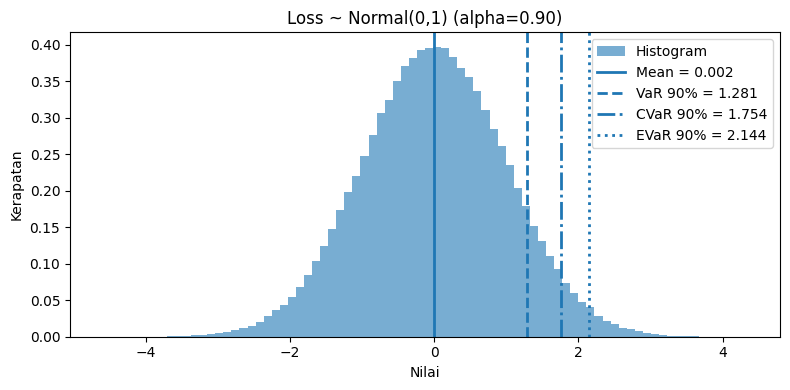

/tmp/ipython-input-1342184514.py:32: RuntimeWarning: overflow encountered in exp
  mgf = lambda t: np.mean(np.exp(t * x))


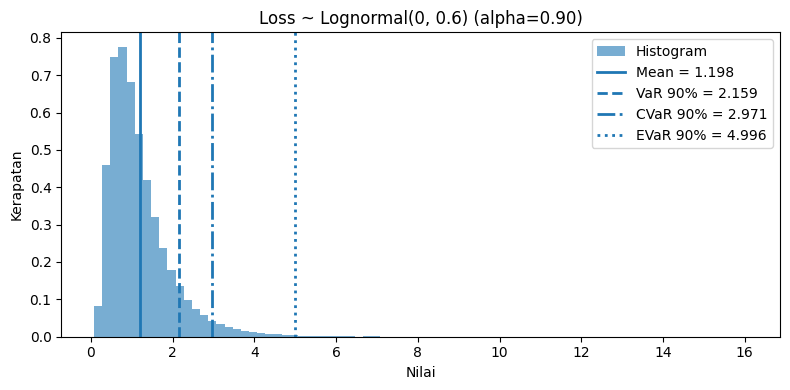

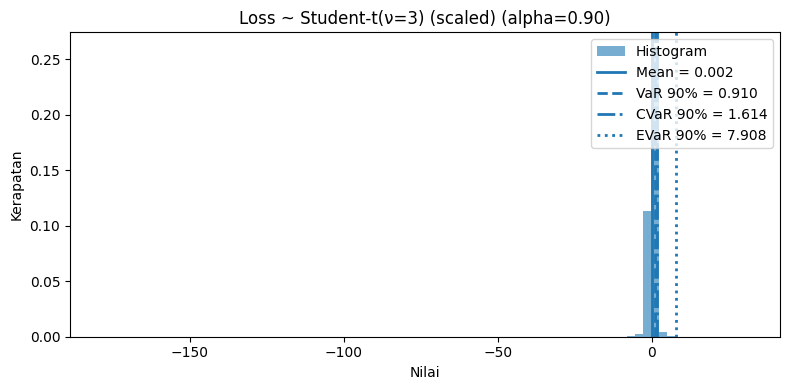

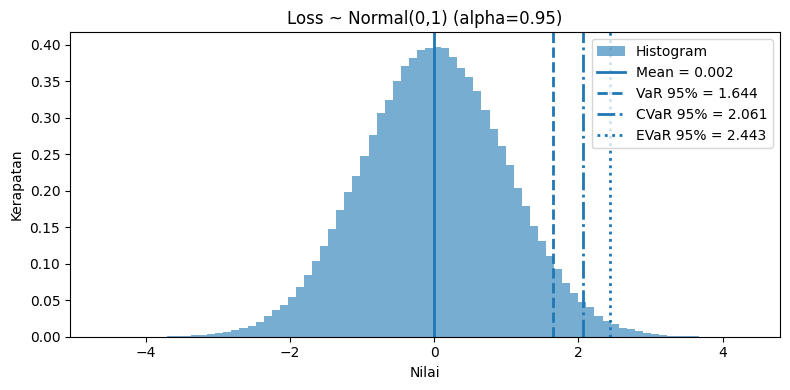

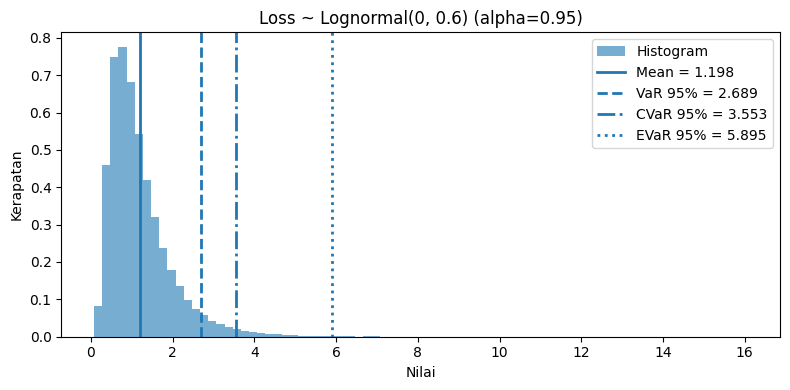

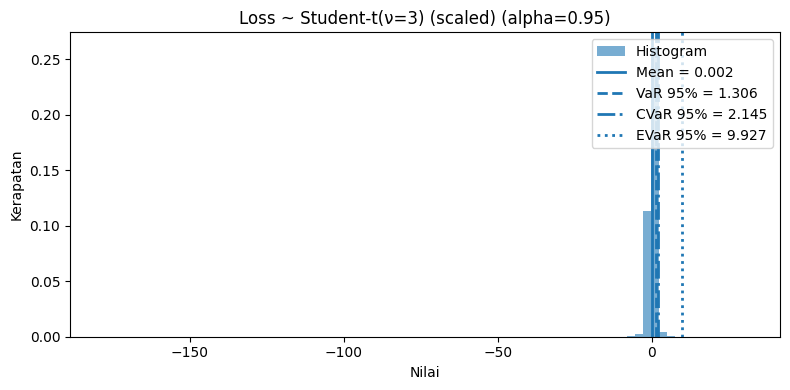

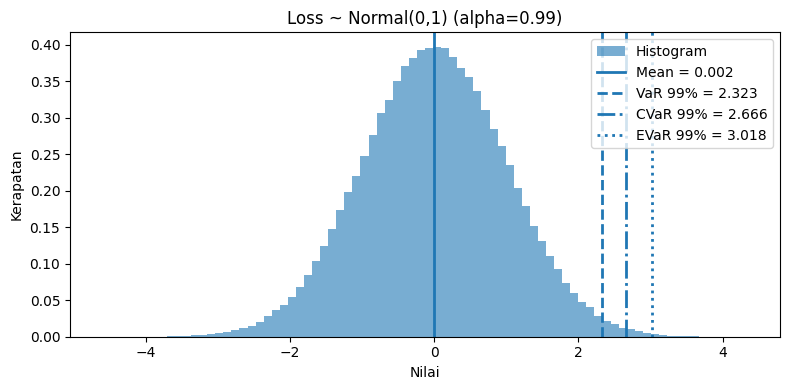

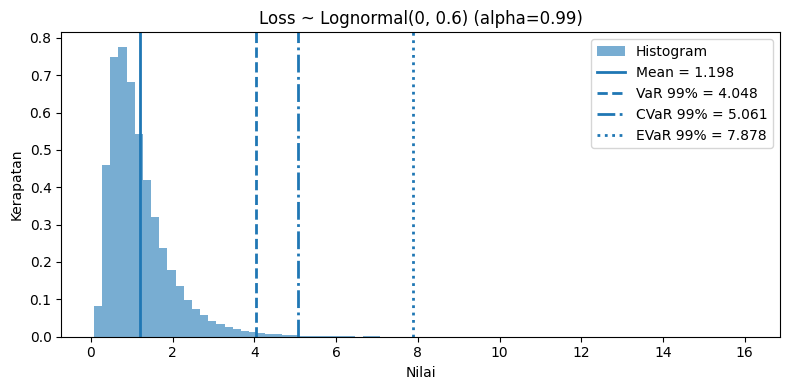

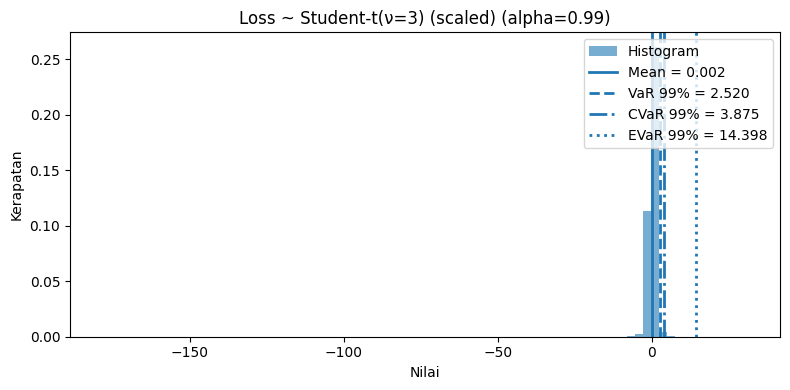

In [ ]:

N = 300000
loss_norm = np.random.normal(0.0, 1.0, size=N)
z = np.random.normal(0.0, 0.6, size=N)
loss_logn = np.exp(z)
nu = 3
t_raw = np.random.standard_t(nu, size=N)
loss_t = t_raw / np.std(t_raw)

summary_tables = []

for a in ALPHAS:
    plot_with_markers(loss_norm, a, 'Loss ~ Normal(0,1)', f'loss_normal_alpha{int(a*100)}.png', tail='right')
    plot_with_markers(loss_logn, a, 'Loss ~ Lognormal(0, 0.6)', f'loss_logn_alpha{int(a*100)}.png', tail='right')
    plot_with_markers(loss_t, a, 'Loss ~ Student-t(ν=3) (scaled)', f'loss_t3_alpha{int(a*100)}.png', tail='right')

summary_tables.append(summarize(loss_norm, 'Loss-Normal(0,1)', 'right'))
summary_tables.append(summarize(loss_logn, 'Loss-Lognormal(0,0.6)', 'right'))
summary_tables.append(summarize(loss_t, 'Loss-Student-t(3)', 'right'))



## 2) Return-style data (ekor kiri)
Untuk *return* \(R\), ukur risiko pada loss \(L=-R\).
Simulasikan return harian dengan outlier negatif agar ekor kiri berat.


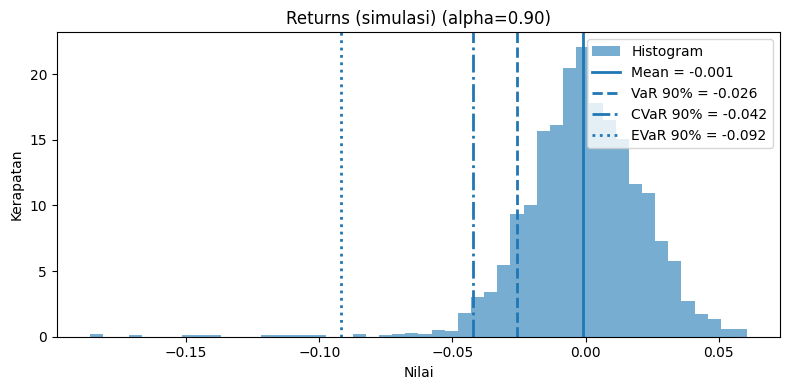

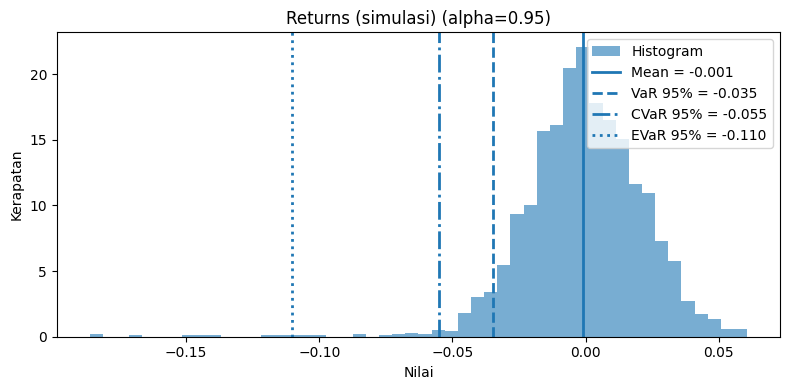

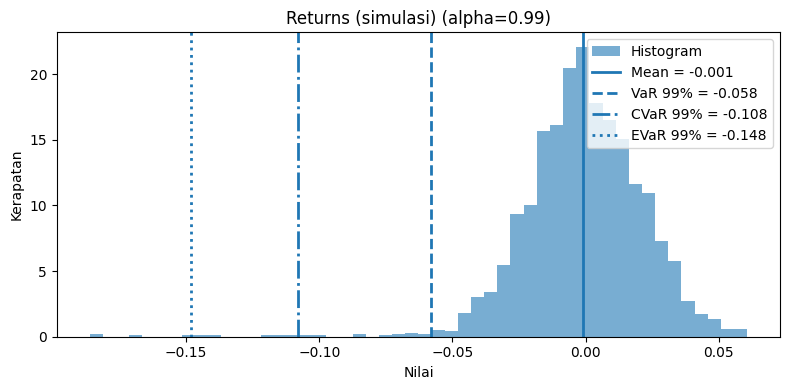

In [ ]:

n = 2000
returns = np.random.normal(0, 0.02, size=n)
outliers = np.random.choice(n, size=20, replace=False)
returns[outliers] += np.random.normal(-0.1, 0.05, size=20)

for a in ALPHAS:
    plot_with_markers(returns, a, 'Returns (simulasi)', f'returns_alpha{int(a*100)}.png', tail='left', bins=50)

summary_tables.append(summarize(returns, 'Returns (left-tail)', 'left'))



## 3) Ringkasan Hasil
Gabungkan seluruh metrik dalam satu tabel dan simpan ke CSV untuk laporan.


In [ ]:

import pandas as pd
summary_df = pd.concat(summary_tables, ignore_index=True)
summary_csv_path = 'summary_risk_measures.csv'
summary_df.to_csv(summary_csv_path, index=False)
summary_df.head(12)


,Dataset,Tail,alpha,Mean,Variance,VaR,CVaR,EVaR
0,"Loss-Normal(0,1)",right,0.90,0.002057,0.996669,1.280907,1.753914,2.143881
1,"Loss-Normal(0,1)",right,0.95,0.002057,0.996669,1.644306,2.061013,2.443457
2,"Loss-Normal(0,1)",right,0.99,0.002057,0.996669,2.322726,2.665614,3.018422
3,"Loss-Lognormal(0,0.6)",right,0.90,1.197570,0.623403,2.158803,2.971123,4.996181
4,"Loss-Lognormal(0,0.6)",right,0.95,1.197570,0.623403,2.688759,3.553276,5.894859
5,"Loss-Lognormal(0,0.6)",right,0.99,1.197570,0.623403,4.047586,5.060939,7.877615
6,Loss-Student-t(3),right,0.90,0.002463,1.000003,0.909988,1.613592,7.907613
7,Loss-Student-t(3),right,0.95,0.002463,1.000003,1.305775,2.145032,9.927173
8,Loss-Student-t(3),right,0.99,0.002463,1.000003,2.520432,3.874693,14.398401
9,Returns (left-tail),left,0.90,-0.000921,0.000522,-0.025968,-0.042460,-0.091650
